# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge aimed at participants who are beginners or have intermediate skill sets in data science and programming. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import xarray as xr

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluation and Tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('cf5657d28bb2408ba8fd775642c2e1cb')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
import os
from glob import glob
import time

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [2]:
crop_presence_data = pd.read_csv("../../data/Crop_Location_Data.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

In [3]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load(items, patch_url=pc.sign, bbox=bbox_of_interest)
    return data

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

## Downloading the Sentinel-1 Data for Reuse

In [4]:
# # Prepare the Folder
# directory="../data/train/sentinel-1-rtc/1-year-202111-202211/vh-vv-1x1"
# if not os.path.exists(directory):
#     print("Creating %s" % (directory))
#     os.mkdir(directory)
#     print("Done")
# else:
#     print("%s already existed" % (directory))

# # Download the Data
# time_slice = "2021-11-01/2022-11-01"
# assests = ['vh','vv']
# vh_vv = []
# for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
#     data = get_sentinel_data(coordinates,time_slice,assests)
#     data.to_netcdf(os.path.join(directory, coordinates+".nc"))

## Calculate RVI

In [5]:
# Function for calculating RVI
def calc_rvi(data):
    '''
    Returns RVI values for a given vv and vh 
    Attributes:
    vv - vertical transmit, vertical receive from satellite
    vh - vertical transmit, horizontal receive from satellite
    '''
    # Calculate RVI
    dop = (data.vv / (data.vv + data.vh))
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*data.vh)/(data.vv + data.vh))
    return rvi

In [136]:
# Function call to extract VV,VH Values
directory = "../../data/train/sentinel-1-rtc/1-year-202111-202211/vh-vv-3x3/"
assests = ['vh','vv']
rvis = []
min_len = 1e6

for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    data = xr.open_dataset(directory + coordinates + ".nc")
    median = data.median(dim=['y', 'x']).compute()
    rvi = calc_rvi(median)
    
    # Rolling Window
    rvi = rvi.rolling(time=10).median()
    rvi = rvi.dropna(dim='time')
    
    # # Update shortes value
    # min_len = len(rvi) if len(rvi) < min_len else min_len
    # rvis.append(rvi.to_numpy())
    median_rvi = rvi.median(dim=['time']).compute().values.tolist()
    min_rvi = rvi.min(dim=['time']).compute().values.tolist()
    max_rvi = rvi.max(dim=['time']).compute().values.tolist()
    var_rvi = rvi.var(dim=['time']).compute().values.tolist()
    rvis.append((median_rvi, min_rvi, max_rvi, var_rvi))
    

# min_len = 40
# for idx in range(len(rvis)):
#     rvis[idx] = rvis[idx][:min_len] 
vh_vv_data = pd.DataFrame(rvis,columns =['median_rvi', 'min_rvi', 'max_rvi', 'var_rvi'])

100%|██████████| 600/600 [00:11<00:00, 50.73it/s]


In [105]:
columns = ['rvi_%d' % (idx) for idx in range(len(rvis[0]))]
vh_vv_data = pd.DataFrame(rvis, columns = columns)

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [137]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [143]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

,Latitude and Longitude,Class of Land,median_rvi,min_rvi,max_rvi,var_rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,0.671606,0.432072,1.043444,0.028557
1,"(10.322364360592521, 105.27843410554115)",Rice,0.659974,0.416051,1.073539,0.029483
2,"(10.321455902933202, 105.25254306225168)",Rice,0.770524,0.428830,1.026411,0.029545
3,"(10.324181275911162, 105.25118037576274)",Rice,0.604202,0.309394,0.855015,0.027667
4,"(10.324635504740822, 105.27389181724476)",Rice,0.778656,0.351220,1.041954,0.047312


## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [144]:
# columns.append('Class of Land')
# crop_data = crop_data[columns]

crop_data = crop_data[['median_rvi', 'min_rvi', 'max_rvi', 'var_rvi', 'Class of Land']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [146]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [147]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [148]:
models = [
    LogisticRegression(random_state=42), 
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BernoulliNB(),
    KNeighborsClassifier(n_neighbors=2)
]

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [149]:
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame({
        "model": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
    })
    
    for model in models:
        accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
        mean_accuracy = round(accuracy.mean(), 4)
        
        recall = cross_val_score(model, X, y, scoring='recall_weighted', cv=cv)
        mean_recall = round(recall.mean(), 4)
        
        precision = cross_val_score(model, X, y, scoring='precision_weighted', cv=cv)
        mean_precision = round(precision.mean(), 4)
        
        f1_score = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv)
        mean_f1_score = round(f1_score.mean(), 4)
        
        cv_accuracies.loc[len(cv_accuracies.index)] = [
            str(model), 
            mean_accuracy, 
            mean_precision, 
            mean_recall, 
            mean_f1_score,
        ]        
    return cv_accuracies

In [150]:
start = time.time()
df_cv = cv_comparison(models, X_train, y_train, 5)
display(df_cv)
print("[TIME]: %.4f" % (time.time()-start))

,model,accuracy,precision,recall,f1_score
0,LogisticRegression(random_state=42),0.9643,0.9662,0.9643,0.9642
1,SVC(random_state=42),0.9714,0.9729,0.9714,0.9714
2,RandomForestClassifier(random_state=42),0.9786,0.9801,0.9786,0.9785
3,GradientBoostingClassifier(random_state=42),0.9762,0.9778,0.9762,0.9761
4,BernoulliNB(),0.9071,0.9116,0.9071,0.9068
5,KNeighborsClassifier(n_neighbors=2),0.9738,0.9757,0.9738,0.9738


[TIME]: 6.7948


In [151]:
df_cv.sort_values(by='f1_score', ascending=False)

,model,accuracy,precision,recall,f1_score
2,RandomForestClassifier(random_state=42),0.9786,0.9801,0.9786,0.9785
3,GradientBoostingClassifier(random_state=42),0.9762,0.9778,0.9762,0.9761
5,KNeighborsClassifier(n_neighbors=2),0.9738,0.9757,0.9738,0.9738
1,SVC(random_state=42),0.9714,0.9729,0.9714,0.9714
0,LogisticRegression(random_state=42),0.9643,0.9662,0.9643,0.9642
4,BernoulliNB(),0.9071,0.9116,0.9071,0.9068


In [155]:
# Create Voting Classifier
vt_model = VotingClassifier(estimators=[
         ('gnb', models[3]), ('rf', models[2]), ('svc', models[1]), ('knn', models[5])], voting='hard')
model = models[2].fit(X_train, y_train)

In [156]:
insample_predictions = model.predict(X_train)

In [157]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       210
        Rice       1.00      1.00      1.00       210

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [158]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

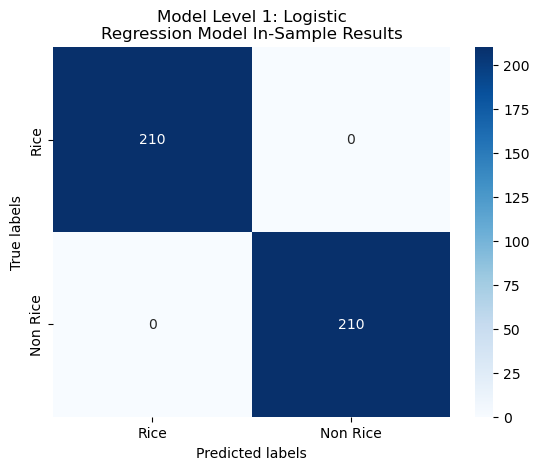

In [159]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [160]:
outsample_predictions = model.predict(X_test)

In [161]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 98.33%
              precision    recall  f1-score   support

    Non Rice       0.98      0.99      0.98        90
        Rice       0.99      0.98      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



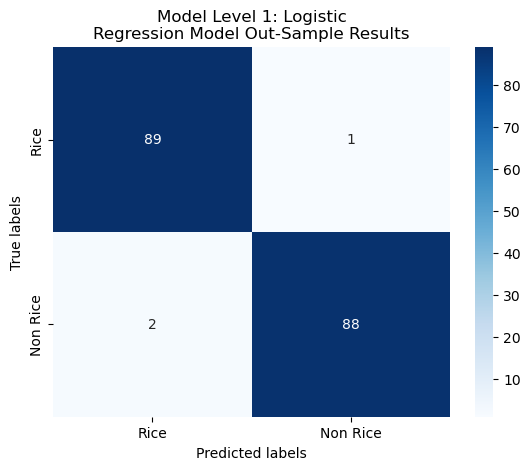

In [162]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

# Hyperparameter Tuning

## Gradient Boosting Classifier

In [34]:
gb_hyperparams = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 4, 6, 8],
}

In [36]:
# Create the model to be tuned
gb_base = GradientBoostingClassifier()

# Create the random search Random Forest
gb_random = RandomizedSearchCV(
    estimator = gb_base, 
    param_distributions = gb_hyperparams, 
    n_iter = 100, 
    cv = 5, 
    random_state = 42, 
    n_jobs = -1
)

gb_grid = GridSearchCV(
    estimator = gb_base, 
    param_grid = gb_hyperparams,
    cv = 5, 
    n_jobs = -1
)

# Fit the random search model
gb_random.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)

# View the best parameters from the random search
print(gb_random.best_params_)
print(gb_grid.best_params_)

KeyboardInterrupt: 

In [ ]:
print(gb_random.best_score_)
print(gb_grid.best_score_)

In [ ]:
gb_best_model = gb_grid.best_estimator_

## Random Forest Model

In [163]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [164]:
# Create the model to be tuned
rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, 
                               n_iter = 200, cv = 5, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# View the best parameters from the random search
rf_random.best_params_

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [166]:
rf_best_model = rf_random.best_estimator_

## SVC

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 
  


# Create the model to be tuned
svc_base = SVC()

svc_random = RandomizedSearchCV(svc_base, param_distributions=param_grid, verbose = 3)
svc_grid = GridSearchCV(svc_base, param_grid=param_grid, verbose = 3)

# Fit the random search model
svc_random.fit(X_train, y_train)
svc_grid.fit(X_train, y_train)

# View the best parameters from the random search
print(svc_random.best_params_)
print(svc_grid.best_params_)

In [ ]:
print(svc_random.best_score_)
print(svc_grid.best_score_)
svc_best_model = svc_grid.best_estimator_

## KNN

In [ ]:
param_grid = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

# Create the model to be tuned
knn_base = KNeighborsClassifier()

knn_random = RandomizedSearchCV(knn_base, param_distributions=param_grid, verbose = 3, n_jobs = -1)
knn_grid = GridSearchCV(knn_base, param_grid=param_grid, verbose = 3, n_jobs = -1)

# Fit the random search model
knn_random.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)

# View the best parameters from the random search
print(knn_random.best_params_)
print(knn_grid.best_params_)

In [ ]:
print(knn_random.best_score_)
print(knn_grid.best_score_)
knn_best_model = knn_grid.best_estimator_

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [95]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../../data/challenge_1_submission_template.csv')
test_file = test_file.rename(columns={"id": "Latitude and Longitude"})
test_file

,Latitude and Longitude,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN
...,...,...
245,"(10.308283266873062, 105.50872812216863)",NaN
246,"(10.582910017285496, 105.23991550078767)",NaN
247,"(10.581547330796518, 105.23991550078767)",NaN
248,"(10.629241357910818, 105.15315779432643)",NaN


In [96]:
# # Prepare the Folder
# directory="../../data/test/sentinel-1-rtc/1-year-202111-202211/vh-vv-1x1"
# if not os.path.exists(directory):
#     print("Creating %s" % (directory))
#     os.makedirs(directory)
#     print("Done")
# else:
#     print("%s already existed" % (directory))

# # Download the Data
# time_slice = "2021-11-01/2022-11-01"
# assests = ['vh','vv']
# vh_vv = []
# for coordinates in tqdm(test_file['Latitude and Longitude']):
#     data = get_sentinel_data(coordinates,time_slice,assests)
#     data.to_netcdf(os.path.join(directory, coordinates+".nc"))

In [176]:
## Function call to extract VV,VH Values
directory = "../../data/test/sentinel-1-rtc/1-year-202111-202211/vh-vv-3x3/"
assests = ['vh','vv']
rvis = []

for coordinates in tqdm(test_file['Latitude and Longitude']):
    data = xr.open_dataset(directory + coordinates + ".nc")
    median = data.median(dim=['y', 'x']).compute()
    rvi = calc_rvi(median)
    
    # Rolling Window
    rvi = rvi.rolling(time=10).median()
    rvi = rvi.dropna(dim='time')
    
    # # Update shortes value
    # min_len = len(rvi) if len(rvi) < min_len else min_len
    # rvis.append(rvi.to_numpy())
    median_rvi = rvi.median(dim=['time']).compute().values.tolist()
    min_rvi = rvi.min(dim=['time']).compute().values.tolist()
    max_rvi = rvi.max(dim=['time']).compute().values.tolist()
    var_rvi = rvi.var(dim=['time']).compute().values.tolist()
    rvis.append((median_rvi, min_rvi, max_rvi, var_rvi))
    

# min_len = 40
# for idx in range(len(rvis)):
#     rvis[idx] = rvis[idx][:min_len] 
submission_vh_vv_data = pd.DataFrame(rvis,columns =['median_rvi', 'min_rvi', 'max_rvi', 'var_rvi'])

# min_len = 40
# for idx in range(len(rvis)):
#     rvis[idx] = rvis[idx][:min_len] 

100%|██████████| 250/250 [00:05<00:00, 48.87it/s]


In [177]:
# columns = ['rvi_%d' % (idx) for idx in range(len(rvis[0]))]
# submission_vh_vv_data = pd.DataFrame(rvis, columns = columns)
submission_vh_vv_data

,median_rvi,min_rvi,max_rvi,var_rvi
0,0.706673,0.353139,1.012318,0.044069
1,0.741589,0.422830,0.907863,0.018446
2,0.502537,0.235619,0.936165,0.042494
3,0.743068,0.611310,0.980097,0.007623
4,0.638161,0.385895,1.003898,0.028080
...,...,...,...,...
245,0.860224,0.740682,1.061623,0.007787
246,0.761293,0.566658,0.911187,0.007474
247,0.859056,0.497536,0.948479,0.013580
248,0.648879,0.190510,0.918891,0.068218


In [178]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [179]:
#Making predictions
final_predictions = rf_best_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [180]:
#Combining the results into dataframe
submission_df = pd.DataFrame(
    {
        'id':test_file['Latitude and Longitude'].values, 
        'target':final_prediction_series.values
    }
)

In [174]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [103]:
submission_df.groupby("target").count()

,id
target,
Non Rice,146
Rice,104


In [129]:
submission_df.groupby("target").count()

,id
target,
Non Rice,154
Rice,96


In [181]:
submission_df.groupby("target").count()

,id
target,
Non Rice,140
Rice,110


In [183]:
#Dumping the predictions into a csv file.
datetime_now = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_df.to_csv("../../output/submission_sentinel_rtc_1_rvi_median_min_max_var_1_year_3x3_rf_hp_tuned.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!